## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )
                    model.view_model()
                    from IPython.display import Image, display
                    display(Image(filename="causal_model.png"))

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(fit_intercept=False),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[-2.16021815]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')


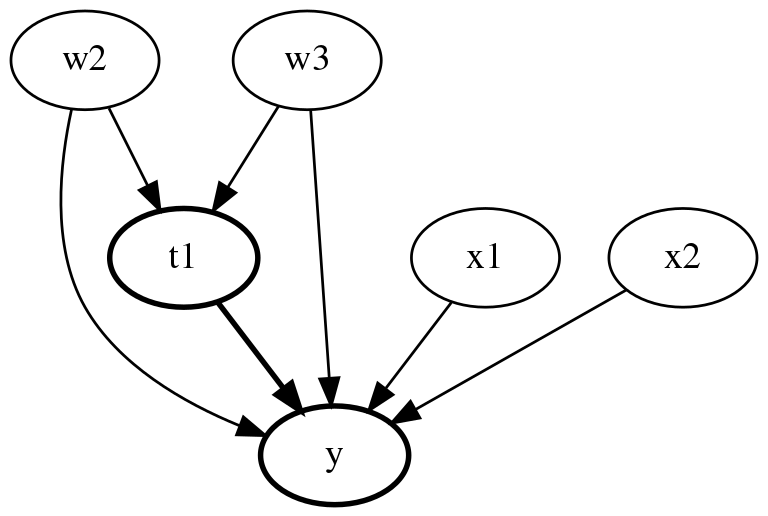

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}}


2022-03-20 20:15:50.483900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 20:15:50.484103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}}


Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.21585430509731, 70.40508337488912, 65.04045602154363, 51.35200884561789, 66.41319376643672]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [2.0929152238389706, -1.1110843846427647, -0.2540771054226735, -0.1469346741706295, 0.6465815042857738]
p_value [0.2846465814215726, 0.2696935715373422, 0.4258007581024964, 0.013852572988622747, 0.4770727604926411]
true value -2.1602181502819833


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.02566399],
       [  0.50710254],
       [  0.39475248],
       [  1.18939194],
       [ -0.82750088],
       [ -0.6717412 ]]), 'confounder=>outcome': array([[101.12607252],
       [ -0.50810067],
       [  0.36814479],
       [ -1.21534504],
       [ -0.25090022],
       [ -0.44676619]]), 'effect

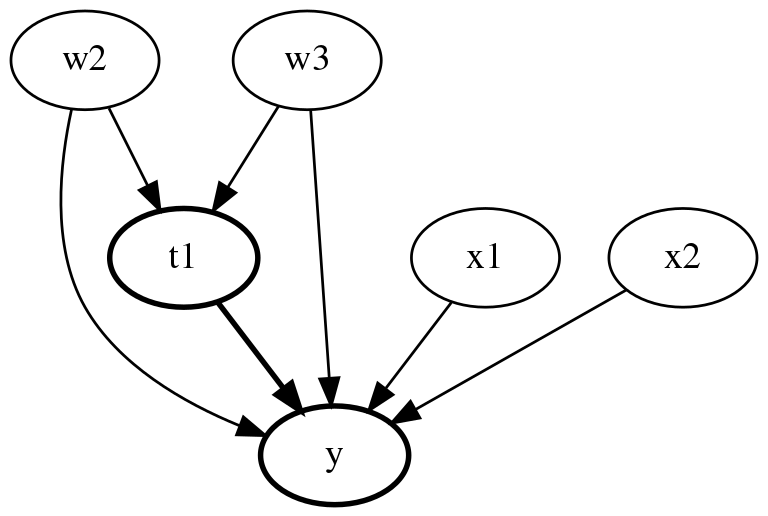

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.6574487667095, 53.429898041643185, 62.7108331661941, 50.00970625778995, 63.0352521639778]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing refute's type
<class 'list'>


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.3891004342734692, -0.06921694510514867, 1.0790696052933428, -0.3929119921316152, 2.4877914264565133]
p_value [0.23991797333558673, 0.4216319530833639, 0.27450321522196186, 0.12792078656210903, 0.2835785799824565]
true value -0.6430416974361974


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.88270080e+01],
       [ 1.78565335e-01],
       [-6.04984285e-01],
       [-3.61862038e-01],
       [-7.25359141e-02],
       [-1.51937973e-01]]), 'confounder=>outcome': array([[ 1.00169212e+02],
       [-1.46817274e+00],
       [-5.86370247e-02],
       [ 4.32271183e-01],
       [-6.19866127e-01

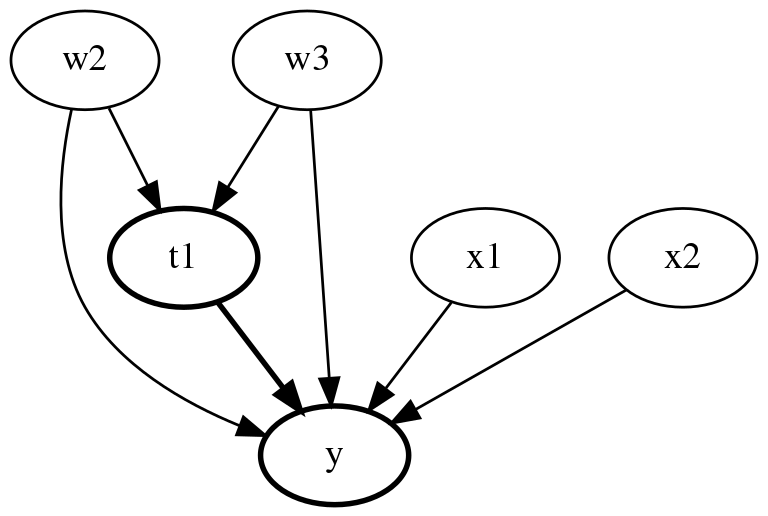

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [53.02491896337497, 56.91924177990161, 53.636885678360315, 53.23262282042114, 53.273245506200624]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.6312168256028098, -0.3792868457551107, 2.334658690330703, -1.145414883431126, 0.8853557411393771]
p_value [0.37925156217988565, 0.38264005612132845, 0.0773380197565436, 0.12514152414934587, 0.42152333891727023]
true value -0.7342836931429669


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.94368161e+01],
       [-7.15446327e-01],
       [-3.80972789e-03],
       [-5.75703765e-01],
       [ 5.38707893e-01],
       [ 5.75890932e-01]]), 'confounder=>outcome': array([[ 1.00201002e+02],
       [ 9.57540295e-01],
       [ 4.69505864e-02],
       [ 1.27826241e+00],
       [-3.91809312e-01],

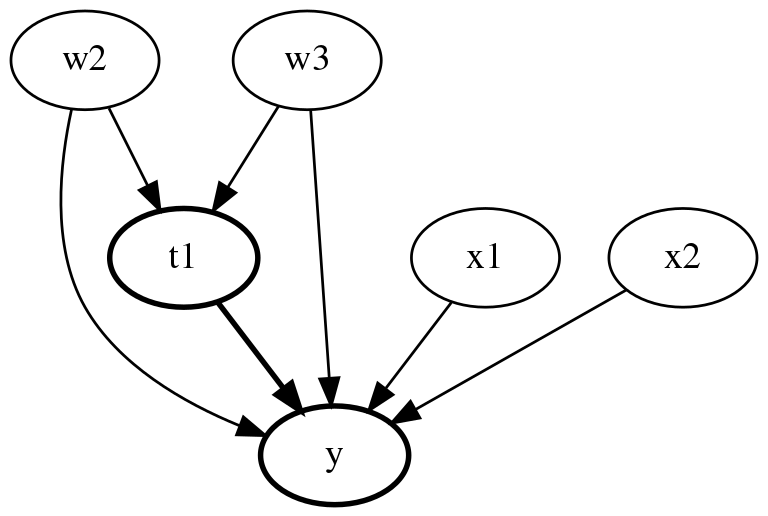

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [57.85581512142886, 52.75026072472895, 57.912781226886864, 50.91874927854064, 57.95184135683232]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.3851812034173827, 3.269845064332407, 2.5336554333210426, 0.7671302927152951, 2.36740710771886]
p_value [2.5116340424867713e-05, 0.10443869363774344, 0.01651518920032031, 0.4391928408976204, 0.16264465758562546]
true value 0.7831569401766588


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.93109069e+01],
       [ 1.11615133e+00],
       [ 1.01206502e+00],
       [-4.00521173e-02],
       [ 8.93156396e-01],
       [-9.85021405e-01]]), 'confounder=>outcome': array([[99.3172471 ],
       [ 0.64194946],
       [ 0.91875612],
       [ 0.73555063],
       [-1.03988095],
       [-1.42740212]]

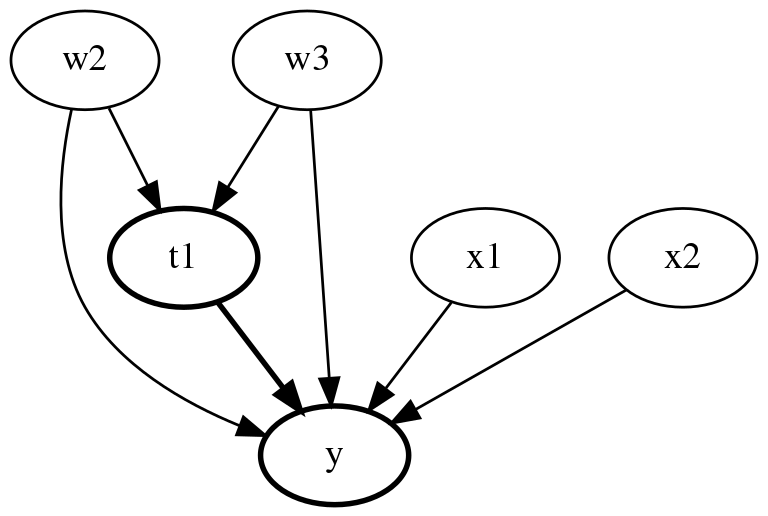

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [64.8745795620197, 70.22942938136646, 67.36206919359368, 61.970660475249154, 65.60254513577934]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.5354598233639674, 0.33023403629426473, -0.8932909295605125, 0.8026334406770725, 2.6446148500615685]
p_value [0.34695839048374477, 0.43776341280377196, 0.2711518949374593, 0.34151093433358704, 0.31080152913479653]
true value 1.398825466975552


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.94416874e+01],
       [-6.61703418e-01],
       [-5.42377714e-01],
       [ 5.35719797e-01],
       [-9.67022324e-02],
       [-1.43870091e+00]]), 'confounder=>outcome': array([[99.75787309],
       [ 0.87753278],
       [-0.62815838],
       [-0.71736392],
       [-0.4816274 ],
       [-1.25295718

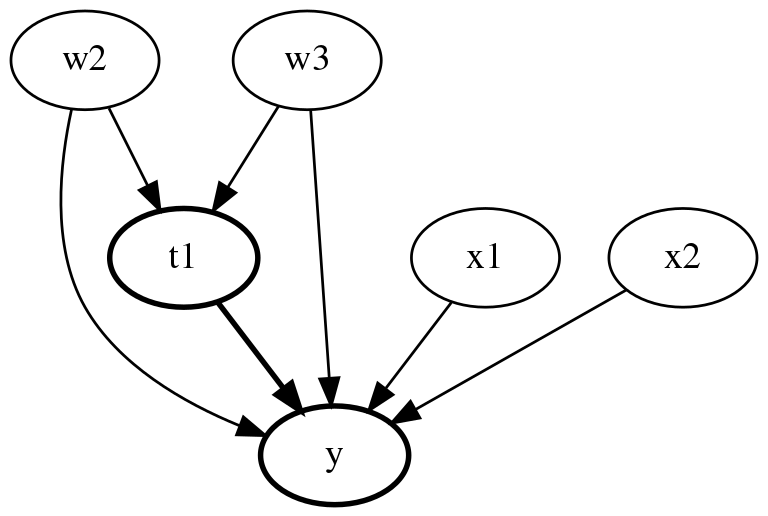

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [63.279004451176206, 53.78926361725462, 62.91694818397311, 62.56013623013749, 62.92885166836902]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.447665266466416, 1.9098279313020168, 1.8035830749653683, 0.9496651342314542, 2.5964004381241965]
p_value [0.3025063951534158, 0.3305293077341013, 0.4042463976431008, 0.3531002843656779, 0.05860903301915886]
true value -0.004290416382844565


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01183140e+02],
       [ 1.14921597e+00],
       [ 5.11881312e-01],
       [-2.21564265e-01],
       [ 4.38246080e-01],
       [ 3.32377472e-02]]), 'confounder=>outcome': array([[ 9.83881355e+01],
       [ 8.78658056e-01],
       [ 1.66636555e+00],
       [-1.34545495e+00],
       [ 3.70000438e-01],
  

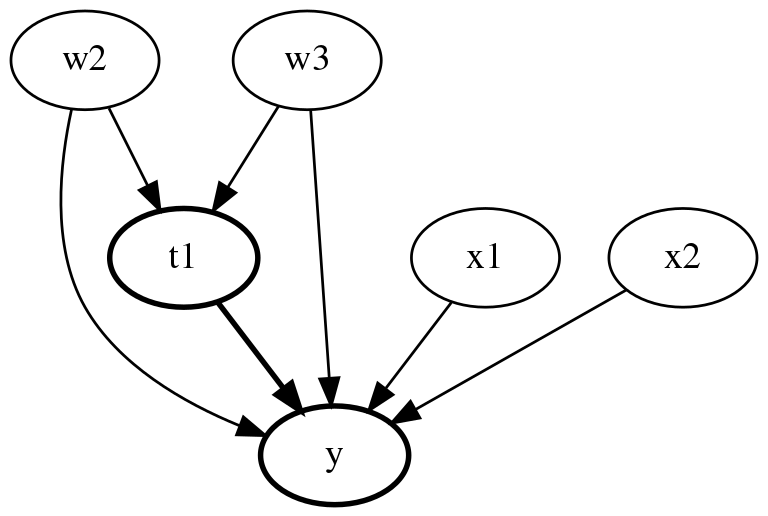

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [67.7620491179214, 63.22028468463368, 66.04258518745037, 60.03065540537139, 66.80282942584445]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.9148791765089779, 0.49152856021692565, 1.1376836492686007, 1.5697546245267089, -0.8205739472281459]
p_value [0.323354670200794, 0.4990854600033845, 0.3949066311624222, 0.18100986322921142, 0.3243933575540936]
true value -0.15874518166603138


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.07667704],
       [ -0.63608279],
       [  0.34550649],
       [  2.03772657],
       [  3.05931256],
       [ -1.02934043]]), 'confounder=>outcome': array([[99.57706028],
       [-1.27692115],
       [-0.37558869],
       [ 1.21111731],
       [-0.45796243],
       [ 0.79212801]]), 'effect_modifie

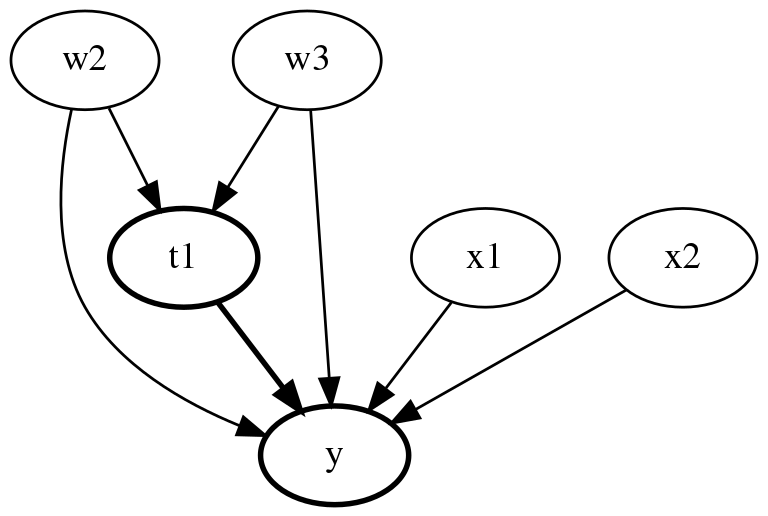

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [56.252602901678436, 59.186402899022205, 57.44025838070222, 53.31189026537523, 57.16926291365019]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing refute's type
<class 'list'>


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.8552144131748314, -2.5206320797461266, -1.2088223343125968, -0.5164579455453776, -1.1076629941934506]
p_value [0.10110074037404515, 0.2664189068095596, 0.1972005460223345, 0.33503112661829637, 0.26703745935256207]
true value -0.15819176623273284


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.93613393],
       [-0.13665447],
       [-0.30895418],
       [-1.99227529],
       [ 0.23114732],
       [ 1.14712176]]), 'confounder=>outcome': array([[99.88579859],
       [ 1.56499414],
       [ 0.21082804],
       [-0.28654916],
       [ 1.43998328],
       [ 0.22607824]]), 'effect_modifie

Co-variance matrix is underdetermined. Inference will be invalid!


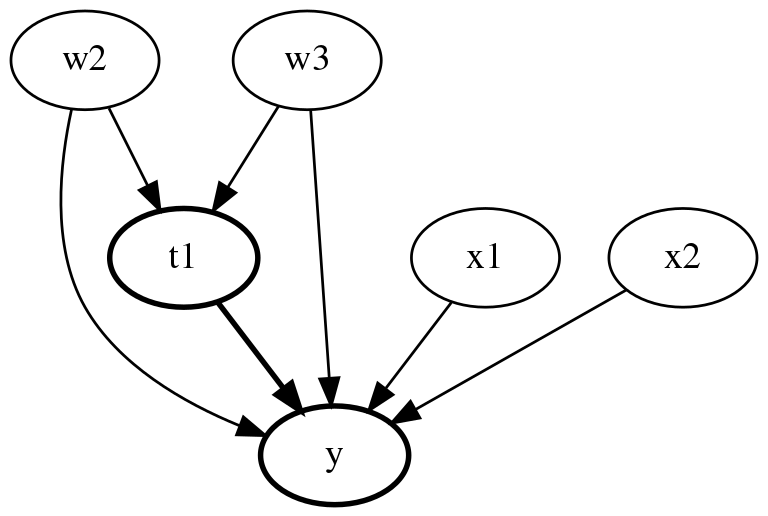

identified_estimand:

 Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_matching


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [68.50631910021632, 77.28400324344548, 70.3957481863207, 62.88513455705642, 68.5125558157075]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.45597698778950424, -1.9932988393340143, -1.1609534377462754, -2.952967386674657e-16, -3.2001418165854494]
p_value [0.49240743338828086, 0.0031491004113481935, 0.3616770952393019, 0.0, 0.027355864480536396]
true value 0.6498470815943337


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.22529231],
       [-1.19227202],
       [ 0.72908529],
       [-0.34284713],
       [ 0.21196776],
       [-0.82985599]]), 'confounder=>outcome': array([[98.23906319],
       [ 0.63395556],
       [ 0.470546  ],
       [-0.87296459],
       [ 1.16944262],
       [-0.71531251]]), 'effect_modifier=>outcome'

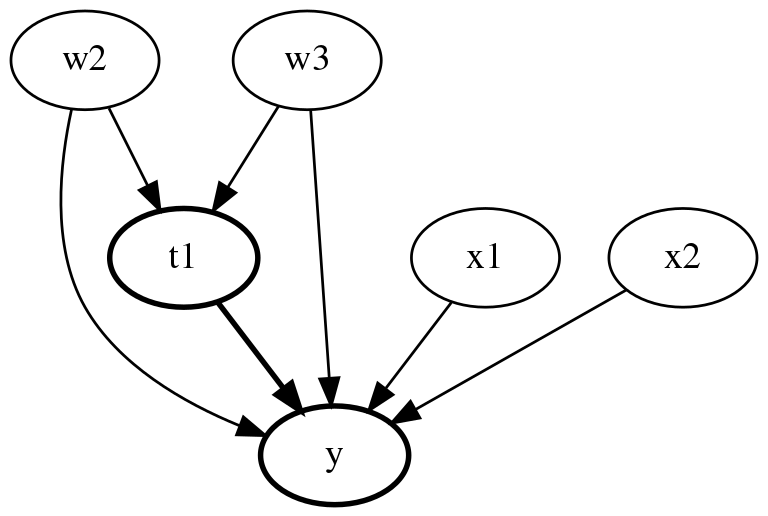

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [69.15035465187597, 82.3626100200028, 68.08979141355687, 78.37691995003675, 67.83204291463188]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.14044711997376796, -0.36566638003095453, 1.240619299645757, 0.38962243159035986, -1.267177719334987]
p_value [0.44627916755173636, 0.38904861092743503, 0.38250380150687746, 0.4597916231574046, 0.16966320266505908]
true value 1.043032467929503


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2022-03-20_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())

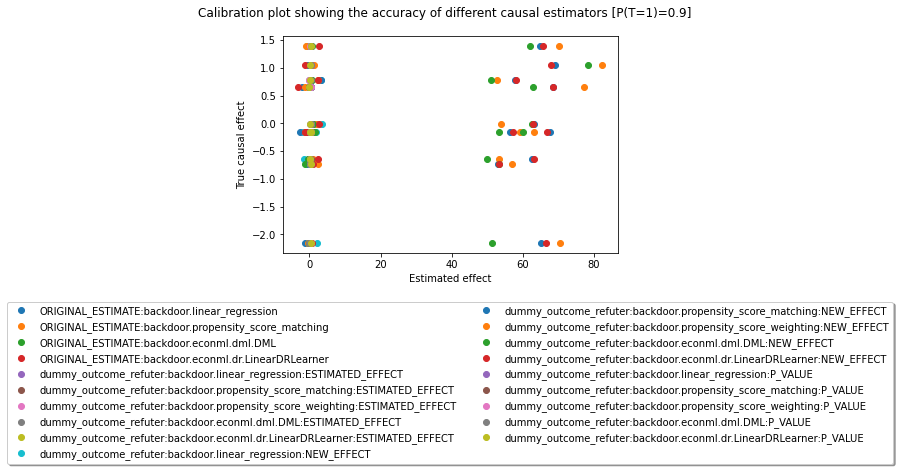

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 63.95603867153549
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 62.95055296158965
ORIGINAL_ESTIMATE:backdoor.linear_regression 62.85628558899655
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 58.46323930340628
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 2.0759501696845177
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 1.8238520901753095
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 1.690312986216254
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 1.4511912092165176
dummy_outcome_refuter:backdoor.propensity_score_matching:P_VALUE 0.8969232299327585
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:P_VALUE 0.889538213727097
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 0.8733632861818805
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 0.8733632861818805
dummy_outcome_

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

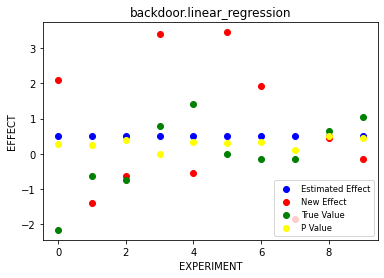

6.745179241632404


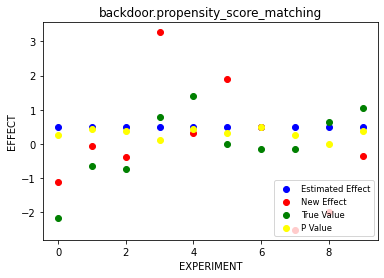

-0.43774988246850527


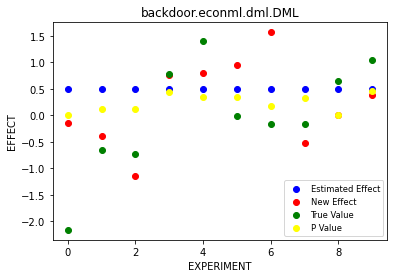

2.277086428462142


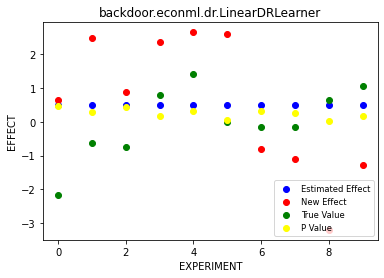

5.232594590444256


<Figure size 432x288 with 0 Axes>

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

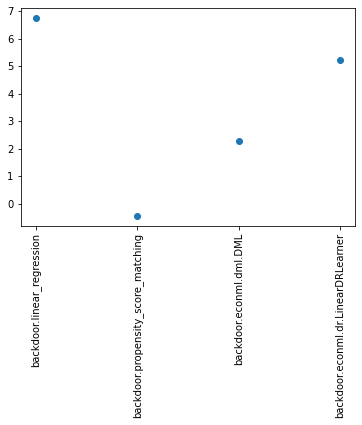

backdoor.linear_regression: 6.745179241632404
backdoor.propensity_score_matching: -0.43774988246850527
backdoor.econml.dml.DML: 2.277086428462142
backdoor.econml.dr.LinearDRLearner: 5.232594590444256


In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.linear_regression': 6.745179241632404,
 'backdoor.econml.dr.LinearDRLearner': 5.232594590444256,
 'backdoor.econml.dml.DML': 2.277086428462142,
 'backdoor.propensity_score_matching': -0.43774988246850527}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 



Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.55362103],
       [  0.80865123],
       [  0.10190771],
       [ -0.62721069],
       [ -0.35094311],
       [ -2.44162526]]), 'confounder=>outcome': array([[99.59531576],
       [ 0.54925049],
       [-0.36750016],
       [ 0.39619088],
       [ 0.53832704],
       [-0.66683889]]), 'effect_modifier=>outcome': array([[-0.55616212],
       [ 0.38279384]]), 'treatment=>outcome': array([[1.04303247]])}
        bias: {'confounder=>treatment': array([0.42138045]), 'confounder=>outcome': array([-0.21332967])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing da

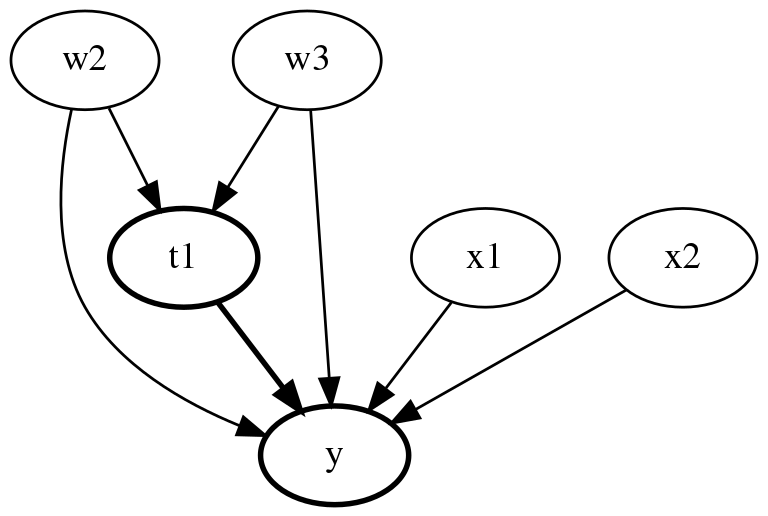

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params

 None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_matching


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [82.57904829697335, 93.63990506055599, 82.5581575994953, 78.07510673373824, 82.79345728189568]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.A

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -268.102259
1      3091.311932
2      1398.889764
3      1906.414723
4     -1634.691994
          ...     
995    -459.991578
996    -884.043640
997    -827.897044
998   -1366.402664
999    2996.614946
Length: 1000, dtype: float64}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c808f10>


divide by zero encountered in double_scalars


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -268.151247
1      3090.802445
2      1395.389292
3      1908.497667
4     -1633.882687
          ...     
995    -458.216362
996    -884.371144
997    -825.794956
998   -1365.605934
999    2997.683638
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c808eb0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -268.620654
1      3093.285800
2      1399.364167
3      1907.465249
4     -1633.873327
          ...     
995    -458.920344
996    -883.979928
997    -826.369294
998   -1364.700545
999    2998.720814
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c810b80>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -266.597240
1      3091.324597
2      1397.881283
3      1907.405168
4     -1634.397994
          ...     
995    -458.401721
996    -884.597366
997    -828.735957
998   -1365.811653
999    2995.996732
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c810d30>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -267.890716
1      3091.997547
2      1399.174580
3      1907.015313
4     -1633.799535
          ...     
995    -459.014984
996    -882.639123
997    -828.173283
998   -1365.835262
999    2997.469493
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [11.30390040811936, 7.2514362614062176, 5.148653183307322, 5.973775727522197, 6.557428998297622]
p_value [0.04236180908722596, 0.2394678006358314, 0.3419151700026071, 0.2880393354199367, 0.33865078200653753]
true value 1.5636726375285916


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.54354783],
       [ -1.10109153],
       [  1.13004916],
       [  0.18463799],
       [ -1.90103601],
       [  0.5248941 ]]), 'confounder=>outcome': array([[98.93512425],
       [ 1.92267036],
       [ 2.86500951],
       [ 0.54743181],
       [-1.21092165],
       [-0.32904593]]), 'effect_modifier=>out

Co-variance matrix is underdetermined. Inference will be invalid!


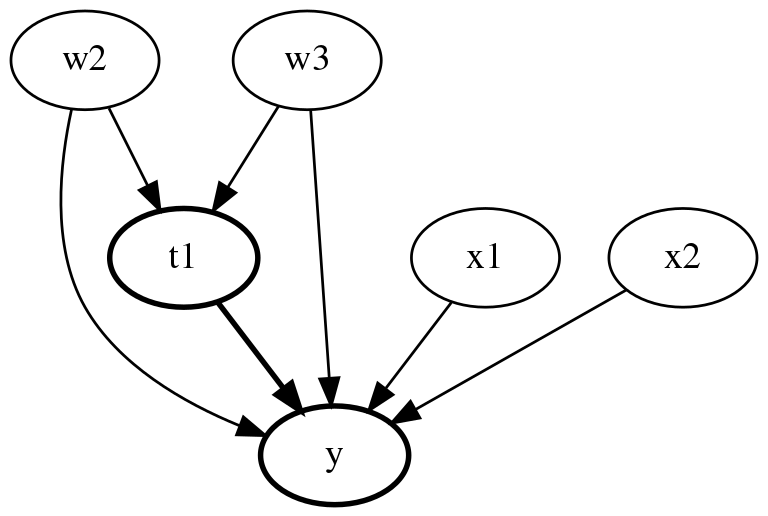

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_matching


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [49.55964047801915, 51.367130780855085, 49.92143094046169, 51.43511986456838, 49.66232181536997]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -267.890716
1      3091.997547
2      1399.174580
3      1907.015313
4     

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       265.134810
1       809.970030
2      3512.900223
3     -4536.463784
4      1015.789070
          ...     
995    1161.056096
996    -485.198700
997    1351.417536
998      93.279739
999     607.701416
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cb06af0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       267.428743
1       809.468396
2      3511.478441
3     -4536.347058
4      1016.933928
          ...     
995    1160.889728
996    -485.292278
997    1351.144550
998      91.952575
999     606.944508
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c8d1a60>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       264.924299
1       811.213176
2      3511.389590
3     -4535.434775
4      1013.996081
          ...     
995    1160.590486
996    -486.946988
997    1351.640778
998      92.064070
999     606.820929
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cc33220>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       266.635353
1       811.026148
2      3511.300958
3     -4535.724388
4      1016.106109
          ...     
995    1159.814182
996    -486.408294
997    1351.932320
998      94.231902
999     606.698151
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb158524070>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       265.032114
1       810.302681
2      3513.674359
3     -4535.997667
4      1015.819598
          ...     
995    1160.272864
996    -485.407186
997    1350.859644
998      93.686024
999     605.430731
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [2.1446462879373946, 4.257267259892182, 9.401254104281696, 4.752016770850927, 15.937872004763426]
p_value [0.4067308937177251, 0.1401787129642681, 0.10914223970963444, 0.22905922404475193, 0.031650729690582295]
true value -1.627008250669471


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.93760425e+01],
       [ 7.43586117e-01],
       [-1.29875835e+00],
       [ 1.54181089e+00],
       [-2.03854116e-01],
       [-1.66556191e-02]]), 'confounder=>outcome': array([[100.06820301],
       [  0.53261228],
       [  0.56935313],
       [ -1.14782919],
       [  1.58762278],
       [  0.5557665

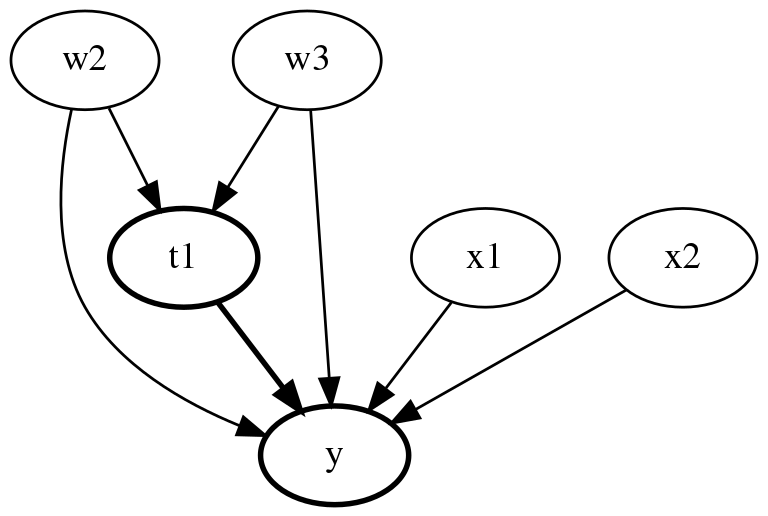

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [67.19561078333993, 70.79713681972358, 67.73996817383382, 62.88012984898532, 67.07217375148059]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       265.032114
1       810.302681
2      3513.674359
3     -4535.997667
4      

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       466.556203
1      2863.821682
2     -1255.470804
3      2192.293127
4     -2855.904083
          ...     
995    1861.669596
996   -2753.088690
997    -823.615312
998    1494.528626
999   -1363.490158
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cc47160>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       465.001851
1      2863.734166
2     -1256.524496
3      2189.868904
4     -2854.501088
          ...     
995    1862.044258
996   -2754.766929
997    -824.061384
998    1495.568766
999   -1363.678288
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c861df0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       464.367805
1      2863.783377
2     -1254.707072
3      2191.978203
4     -2854.373325
          ...     
995    1859.741023
996   -2754.931639
997    -827.883951
998    1496.939678
999   -1365.608848
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c710c40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       465.841492
1      2862.029171
2     -1255.817741
3      2189.992532
4     -2854.524051
          ...     
995    1859.503740
996   -2754.024346
997    -825.217256
998    1495.232540
999   -1363.829431
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c4d5340>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       464.656448
1      2863.167235
2     -1255.379718
3      2189.528106
4     -2856.010038
          ...     
995    1861.813882
996   -2751.412013
997    -825.332070
998    1496.842499
999   -1363.710477
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [4.462754105032427, -0.4947801315473127, 4.513385645928362, 3.834260683137895, 1.046773869527649]
p_value [0.2864901558800753, 0.45334264371756705, 0.28881703795250546, 0.2592161428256232, 0.4741912125991398]
true value -0.4202083982914195


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.138395  ],
       [  0.66779692],
       [ -1.2675515 ],
       [ -0.71442687],
       [  0.57138894],
       [ -1.32973298]]), 'confounder=>outcome': array([[98.71261124],
       [ 0.28977117],
       [ 1.26208023],
       [ 0.82552492],
       [ 1.50654411],
       [-0.57610066]]), 'effect_modifier=>o

Co-variance matrix is underdetermined. Inference will be invalid!


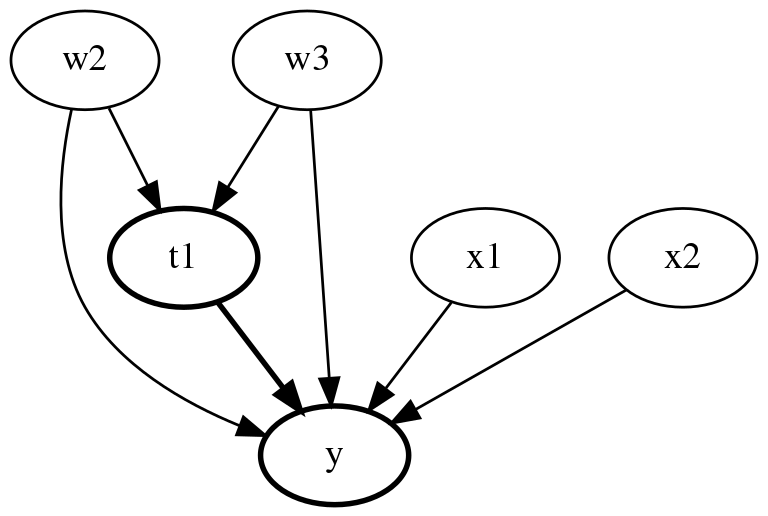

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_matching


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.7448822622582, 66.63537490673737, 62.46733098115639, 63.44246092774517, 62.28808039532347]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       464.656448
1      2863.167235
2     -1255.379718
3      2189.528106
4     -2

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1869.029294
1      3401.375293
2      1942.926265
3     -3801.125795
4     -3019.372727
          ...     
995    1113.660287
996   -1202.159275
997   -1875.016986
998      99.571599
999    1027.924472
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c734cd0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1869.890273
1      3401.296647
2      1942.437718
3     -3802.087690
4     -3020.266252
          ...     
995    1115.378988
996   -1201.856863
997   -1876.193767
998      99.219599
999    1028.403770
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9ca03f40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1869.610640
1      3404.556750
2      1943.933786
3     -3802.266158
4     -3019.656011
          ...     
995    1114.736714
996   -1201.835922
997   -1875.649029
998     100.017013
999    1028.694692
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c707370>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1870.114071
1      3402.784173
2      1941.715690
3     -3802.576350
4     -3020.859757
          ...     
995    1114.450307
996   -1202.588853
997   -1875.906430
998      99.830145
999    1027.202221
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c808f40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1868.129316
1      3402.582614
2      1943.931593
3     -3801.185153
4     -3019.064127
          ...     
995    1115.692724
996   -1200.601991
997   -1876.748004
998     100.267132
999    1029.007004
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [6.489465392615839, 10.824421828940638, 8.908603546818231, 4.734079531626364, 3.9068725343098563]
p_value [0.02940551072172958, 0.0702199961878823, 0.19240399183180967, 0.32736842656691345, 0.32904330447762004]
true value 0.2718304546729197


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.81836692e+01],
       [ 2.47760129e+00],
       [ 1.76438663e+00],
       [-6.29048821e-02],
       [ 2.09878460e-01],
       [ 1.31466851e-01]]), 'confounder=>outcome': array([[102.21977097],
       [ -0.77804449],
       [  1.52180316],
       [ -0.832457  ],
       [  1.12175011],
       [  0.6694133

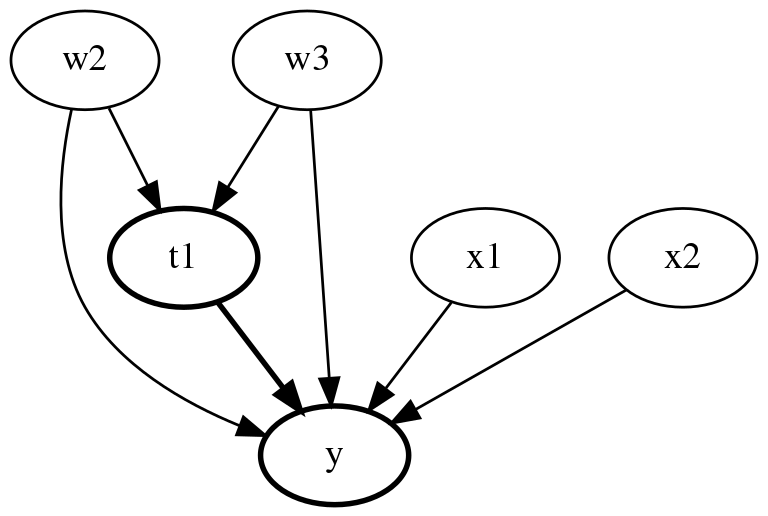

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [54.68209415512192, 48.599747885313135, 50.938840877227804, 43.53688127533345, 54.96246023676153]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      1868.129316
1      3402.582614
2      1943.931593
3     -3801.185153
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -611.560422
1      2085.175870
2      -359.133510
3      -923.211230
4       302.582739
          ...     
995     101.228197
996    -778.128544
997    2141.122737
998   -3295.688809
999   -2029.440126
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c534d30>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -610.960719
1      2083.271681
2      -356.443012
3      -922.373158
4       301.537120
          ...     
995     104.384315
996    -777.344325
997    2141.267271
998   -3297.735984
999   -2029.186324
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c534f70>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -611.641307
1      2084.513652
2      -359.304616
3      -922.191436
4       301.659034
          ...     
995     104.158687
996    -777.633983
997    2140.061204
998   -3297.934682
999   -2029.160693
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c534790>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -611.259513
1      2085.032085
2      -358.263795
3      -923.489532
4       303.066257
          ...     
995     103.785324
996    -778.160424
997    2139.867530
998   -3296.607899
999   -2029.352445
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c534c40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -613.293966
1      2083.015252
2      -357.727898
3      -923.619605
4       302.843817
          ...     
995     102.892708
996    -778.536207
997    2137.846184
998   -3294.076819
999   -2026.775530
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [7.640367370180047, 3.077710331634722, -0.8174609187925054, 1.7877956045699919, -1.609700844459206]
p_value [0.0002383883555993276, 0.4358679687220849, 0.40167346997133335, 0.3593626265883955, 0.18778410128443734]
true value 1.0774793812218513


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.98161318e+01],
       [ 7.67455813e-01],
       [ 3.62915691e-01],
       [ 1.05586344e+00],
       [ 7.75895439e-03],
       [-1.09367047e+00]]), 'confounder=>outcome': array([[ 9.99532559e+01],
       [-1.27434302e+00],
       [-1.80558175e+00],
       [-4.47829123e-02],
       [ 6.74768202e-01],
 

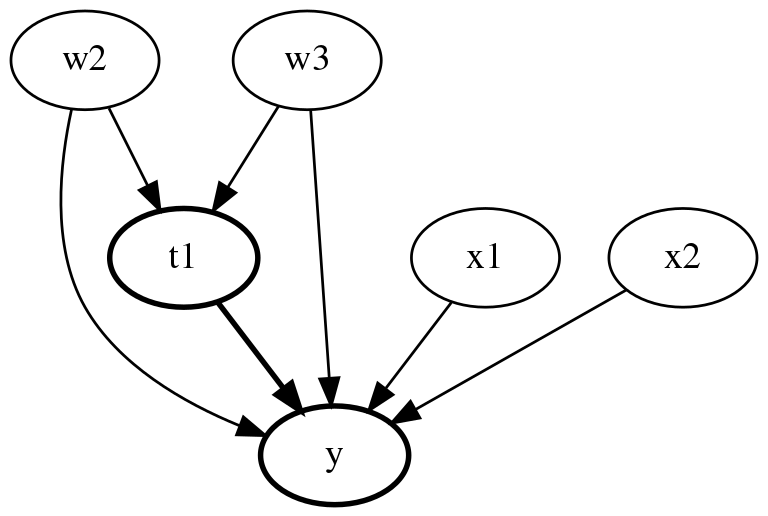

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.90195149087615, 62.14326858425973, 60.78154476044857, 56.52686648126895, 60.99134237417991]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      -613.293966
1      2083.015252
2      -357.727898
3      -923.619605
4      

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3940.006143
1        57.875134
2      -538.445820
3      2165.009963
4       884.111905
          ...     
995   -1574.229519
996    1007.070162
997   -3138.699445
998    1731.831128
999   -2057.310511
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c4d5490>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3940.934745
1        59.032221
2      -537.947101
3      2168.746645
4       883.944058
          ...     
995   -1576.597922
996    1007.114788
997   -3135.922153
998    1731.511928
999   -2055.909669
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c3efdc0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3940.015358
1        57.136932
2      -537.097275
3      2166.695690
4       884.343557
          ...     
995   -1576.491235
996    1007.408465
997   -3138.089805
998    1731.398160
999   -2055.480534
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c850160>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3939.466169
1        56.716418
2      -536.303930
3      2166.597613
4       883.777567
          ...     
995   -1575.552812
996    1005.490149
997   -3136.488114
998    1731.955529
999   -2055.830075
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c4ebe20>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3941.446499
1        56.028706
2      -538.269766
3      2166.394087
4       884.119455
          ...     
995   -1575.765882
996    1007.516089
997   -3139.256146
998    1732.163642
999   -2056.692610
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.660603786059558, 9.502438736632557, 10.641296012021716, 0.8240471503601821, -1.306912551586894]
p_value [0.3623699585543172, 0.13533392433080038, 3.742748678297945e-08, 0.4920791292376824, 0.44480112296935204]
true value -1.1530799063330788


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.00440077e+02],
       [ 6.10206198e-02],
       [ 6.47894803e-01],
       [-1.08516042e+00],
       [ 9.13814565e-01],
       [ 6.49795595e-01]]), 'confounder=>outcome': array([[ 9.97464988e+01],
       [ 9.55449622e-01],
       [-6.67849569e-02],
       [ 3.76789498e-01],
       [ 1.14456304e+00],
 

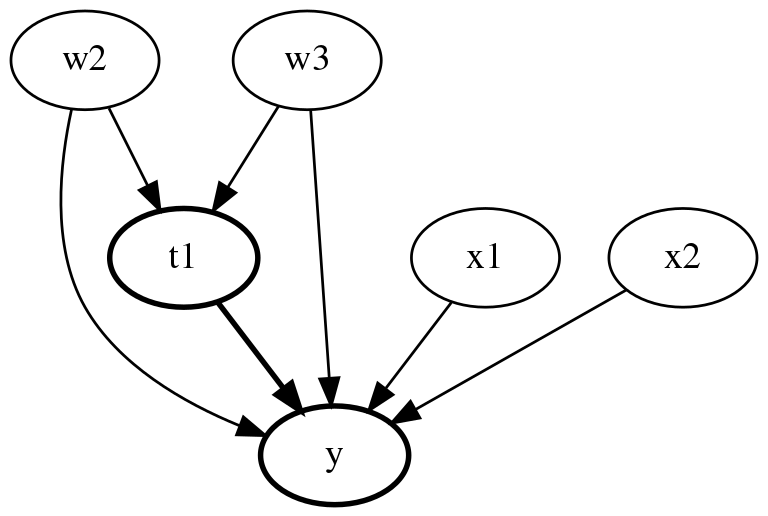

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.04316243835534, 68.45048086874402, 64.49918743705354, 57.73476569915405, 64.9157693535279]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -3941.446499
1        56.028706
2      -538.269766
3      2166.394087
4       

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2107.816985
1     -2426.898726
2      1542.586302
3      -129.918479
4     -4101.928275
          ...     
995    1150.392402
996    1617.615259
997    -479.641578
998    2581.244987
999    -364.084694
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c850520>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2107.056942
1     -2426.313322
2      1541.542649
3      -131.607063
4     -4100.820905
          ...     
995    1149.473059
996    1615.804367
997    -478.657442
998    2579.157048
999    -364.131825
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9dd45490>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2105.252068
1     -2426.820050
2      1541.577361
3      -129.529517
4     -4101.243332
          ...     
995    1150.321510
996    1618.956077
997    -479.136696
998    2579.593041
999    -365.491090
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9dd0bfa0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2108.037327
1     -2426.114242
2      1541.415935
3      -130.307257
4     -4101.434762
          ...     
995    1149.459010
996    1618.285439
997    -479.590240
998    2579.783742
999    -366.096546
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb046539880>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2106.902487
1     -2426.664068
2      1542.390334
3      -131.460297
4     -4099.631394
          ...     
995    1148.775860
996    1616.640938
997    -478.259320
998    2579.284686
999    -366.936090
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.309063810505052, 15.423054550472674, 14.657223090623756, 12.764931213675306, 20.648387470879335]
p_value [0.09464160824074319, 0.24695774680744548, 0.07235351328516877, 0.1347308889832105, 0.029623453780040457]
true value 1.7075619894796057


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.91681818e+01],
       [-5.85033940e-02],
       [ 5.40793055e-01],
       [-6.63317348e-01],
       [ 1.16809183e+00],
       [ 2.71740312e-01]]), 'confounder=>outcome': array([[99.45939974],
       [-0.49296959],
       [-0.32927634],
       [ 0.4369036 ],
       [-0.26957969],
       [-0.87605353]

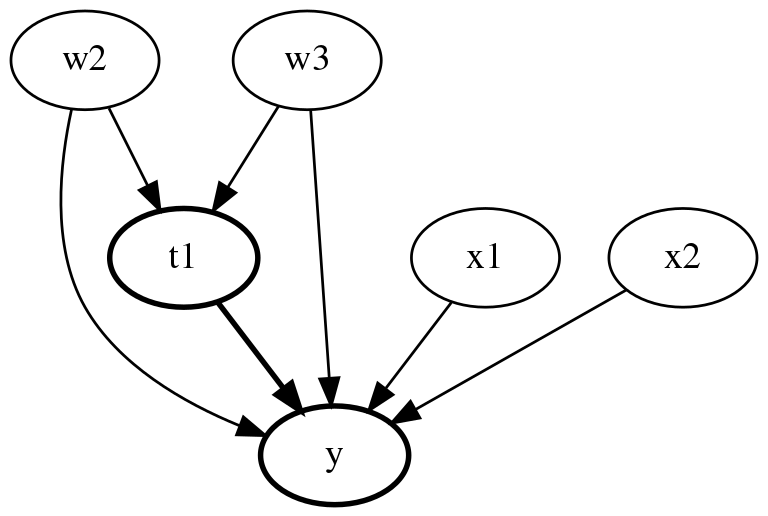

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [63.37229404077416, 58.9770434400301, 64.14621436022367, 58.54347891723342, 63.448287471542045]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0      2106.902487
1     -2426.664068
2      1542.390334
3      -131.460297
4     -

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1951.400102
1      -430.581020
2      -232.015938
3     -2087.157714
4        66.191357
          ...     
995    2237.671248
996     667.310916
997   -3565.628209
998    -269.807913
999    1232.508037
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7fb04aec0af0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1952.577102
1      -426.524766
2      -234.026830
3     -2085.222343
4        66.177115
          ...     
995    2236.274092
996     667.715330
997   -3564.500007
998    -269.398198
999    1231.757277
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c767b80>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1953.244343
1      -428.713277
2      -231.456178
3     -2087.536895
4        66.916537
          ...     
995    2237.682351
996     668.525614
997   -3564.042359
998    -271.068384
999    1230.880716
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9de41d60>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1951.611638
1      -426.637854
2      -236.134710
3     -2086.709449
4        64.143112
          ...     
995    2238.378840
996     666.808738
997   -3562.871208
998    -270.491833
999    1231.238947
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c8f1670>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1951.761944
1      -427.268123
2      -232.476258
3     -2087.221775
4        65.784166
          ...     
995    2238.370380
996     665.829014
997   -3563.524784
998    -271.895238
999    1228.772586
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.4961042747015236, 9.845226335401339, 7.846505244911273, 2.447142034250111, 3.3551810523535934]
p_value [0.3682185016906667, 0.2649484101592997, 0.20482027533564706, 0.34537406046142805, 0.3436112742267261]
true value 0.40729453036142144


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[9.83595442e+01],
       [1.32841310e+00],
       [4.73810127e-01],
       [8.91797943e-02],
       [6.25792837e-01],
       [1.53375622e+00]]), 'confounder=>outcome': array([[ 9.84483212e+01],
       [ 6.09160632e-01],
       [-4.88511208e-02],
       [ 4.16060410e-01],
       [-9.44327068e-02],
       [ 2

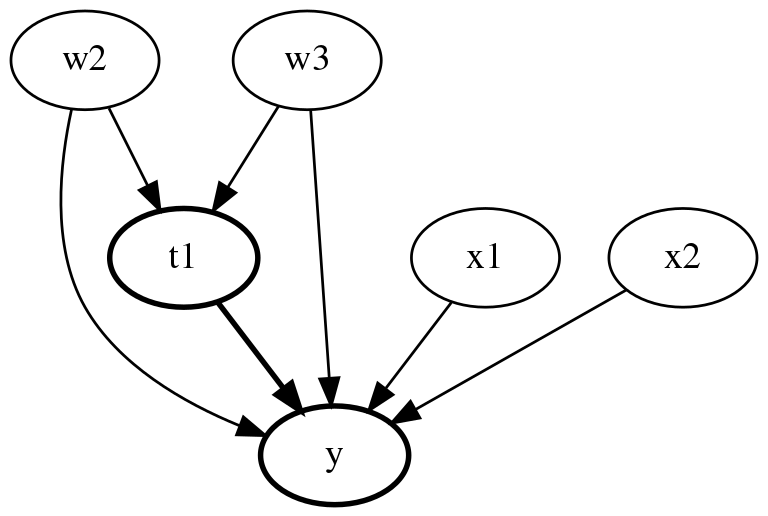

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [66.00713410099637, 56.333282345047934, 66.40753990199842, 71.85247533841225, 65.90033605418922]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0     -1951.761944
1      -427.268123
2      -232.476258
3     -2087.221775
4     

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -15.196140
1      -279.573157
2       780.549610
3      1172.971374
4       765.662503
          ...     
995   -2076.934104
996     131.930140
997    1111.802991
998    1092.987857
999   -2325.761159
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9dd0ac40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -13.127734
1      -280.773051
2       779.712511
3      1169.006962
4       767.928622
          ...     
995   -2075.169433
996     130.912345
997    1113.427780
998    1094.925611
999   -2324.386684
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cc9b5b0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -14.064421
1      -279.653484
2       781.668954
3      1169.923442
4       765.448493
          ...     
995   -2075.583794
996     131.511478
997    1111.078520
998    1094.565099
999   -2326.350142
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c50eaf0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -14.870922
1      -281.585064
2       780.581521
3      1169.210106
4       766.186631
          ...     
995   -2073.476784
996     131.482516
997    1112.624108
998    1093.018824
999   -2325.871663
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cbe5d60>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -13.973706
1      -282.227817
2       780.927343
3      1170.358899
4       766.742834
          ...     
995   -2074.514779
996     131.634136
997    1113.488895
998    1093.011181
999   -2324.553145
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.641824786384424, -0.008955685695380033, 0.841501281715567, 1.8786241492870768, -0.22377242475281314]
p_value [0.1380822161719502, 0.485086124452766, 0.48682337795745717, 0.3568378966178454, 0.45107395669526995]
true value -2.3472190598405294


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.19789996],
       [  1.28639011],
       [ -1.47857583],
       [  0.22886352],
       [  0.5130441 ],
       [  1.02902275]]), 'confounder=>outcome': array([[101.06032215],
       [ -0.88876898],
       [ -0.30344102],
       [ -0.9875432 ],
       [ -1.71490036],
       [ -0.1811362 ]]), 'effect_

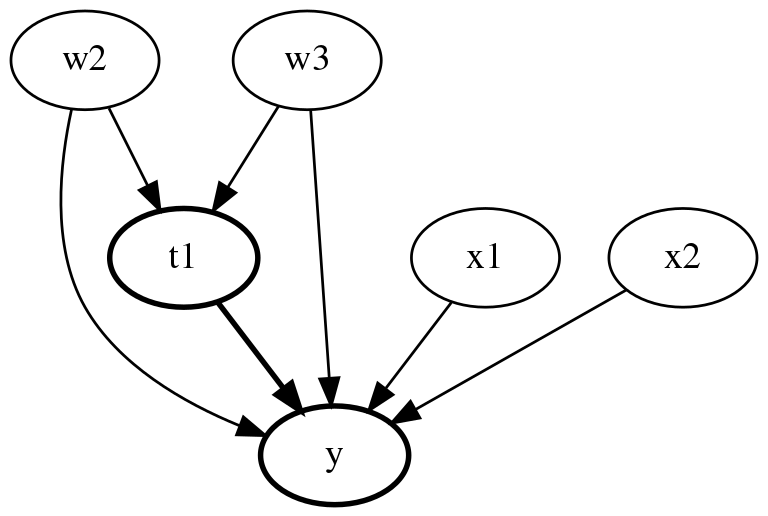

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_sco

divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
propensity_score_weighting
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, 'econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, 'econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [46.77177553626156, 52.2041236496697, 47.25887731206704, 27.715622055055274, 47.46288348393391]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       -13.973706
1      -282.227817
2       780.927343
3      1170.358899
4      

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       903.312521
1      1374.710658
2      -928.743749
3     -1010.232128
4        41.016032
          ...     
995    -806.820152
996    2445.177241
997    1161.375072
998     387.432267
999     997.818019
Length: 1000, dtype: float64}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9cacd0d0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       903.628532
1      1373.779170
2      -926.835565
3     -1009.887655
4        40.572287
          ...     
995    -806.398003
996    2443.298073
997    1160.288260
998     387.683139
999     999.822091
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9c8611c0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       902.223348
1      1373.433385
2      -924.481668
3     -1011.004643
4        38.741596
          ...     
995    -804.520089
996    2444.155225
997    1162.623017
998     386.748922
999     996.020121
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9dd45be0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       903.516138
1      1374.677365
2      -926.204367
3     -1009.776309
4        40.619860
          ...     
995    -807.420520
996    2444.782773
997    1161.534650
998     388.226191
999     998.486042
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7faf9dd42f70>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7fb04ac00160>, 'unobserved_confounder_values': 0       901.687764
1      1372.355465
2      -924.904696
3     -1009.611363
4        41.314998
          ...     
995    -805.361238
996    2444.371479
997    1162.215976
998     387.326429
999     999.969821
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.6841080872482875, 8.77515780542652, 6.445123397529999, 3.9695575210615104, 0.3134585090102121]
p_value [0.48602406699494244, 2.5268983369895157e-19, 0.19202164459637933, 0.3907423091845138, 0.4881057111162118]
true value -1.580777965955537


Completed all experiments. Saving the data...
Data has been saved in  results/Test_2_2022-03-20_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())

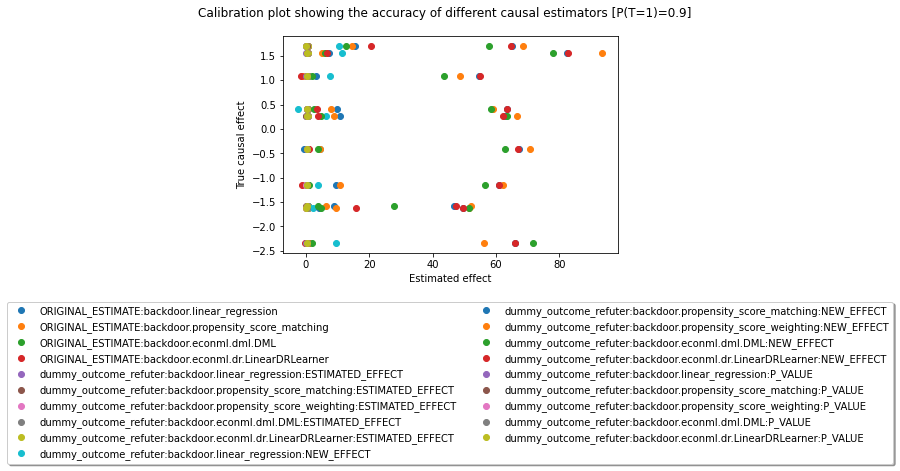

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 63.12479489287623
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 62.15975668060298
ORIGINAL_ESTIMATE:backdoor.linear_regression 62.09580481708018
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 57.384336172932024
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 7.347641977619976
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 7.0702575346901595
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 6.174788195733241
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 5.640806894803817
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 4.506668497416721
dummy_outcome_refuter:backdoor.linear_regression:P_VALUE 1.330096404757747
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:P_VALUE 1.293166809125902
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.2797882604285742
dummy_outcome_refuter:backdoor.propensity_

In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

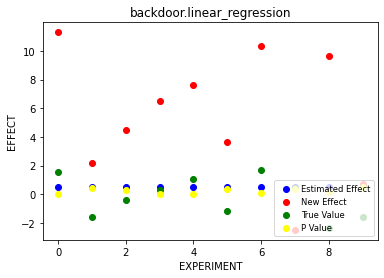

53.84062975938087


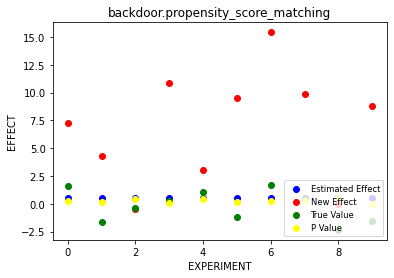

68.45297729256416


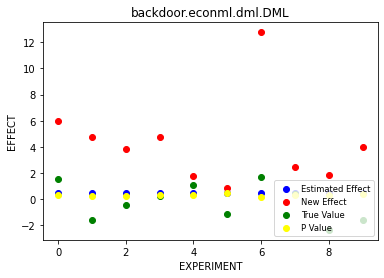

42.96623038634156


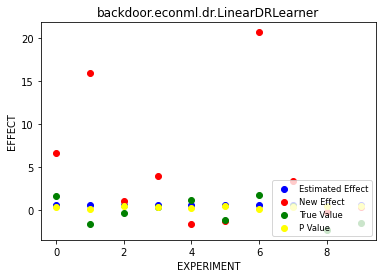

48.625588618342775


<Figure size 432x288 with 0 Axes>

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

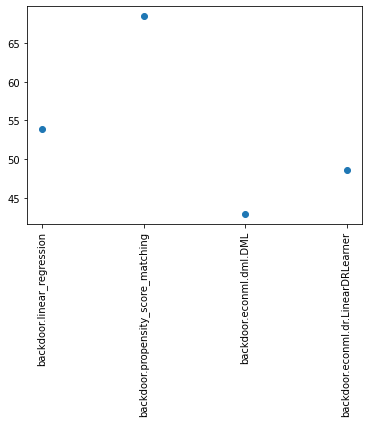

backdoor.linear_regression: 53.84062975938087
backdoor.propensity_score_matching: 68.45297729256416
backdoor.econml.dml.DML: 42.96623038634156
backdoor.econml.dr.LinearDRLearner: 48.625588618342775


In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.propensity_score_matching': 68.45297729256416,
 'backdoor.linear_regression': 53.84062975938087,
 'backdoor.econml.dr.LinearDRLearner': 48.625588618342775,
 'backdoor.econml.dml.DML': 42.96623038634156}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Linear DR Learner 
3. Propensity Score Matching
4. Linear Regression

#### We can see that this ranking produces the same top-ranked estimator as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a close-to-correct ranking amongst methods.